In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [3]:
def diff_percent(a,ref):
    return 100*((a-ref)/ref)

print(diff_percent(65,70.0))

-7.142857142857142


In [4]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff 
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

In [5]:
def bland_altman_plot(Dm_data, AAA_data, structure, metric, *args, **kwargs):
    Dm_data     = np.asarray(Dm_data)
    AAA_data     = np.asarray(AAA_data)
    z_stat, p_val = wilcoxon(Dm_data, AAA_data)
    mean      = np.mean([Dm_data, AAA_data], axis=0)
    diff      = Dm_data - AAA_data                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    md_percent = diff_percent(Dm_data.mean(), AAA_data.mean())
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # plt.scatter(mean, diff, *args, **kwargs)
    plt.scatter(AAA_data, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('AAA Dose (Gy)')
    plt.ylabel('Dm - AAA Difference (Gy)')
   # plt.title( str(np.round(md, decimals = 3)) + ' Gy (' + str(np.round(md_percent, decimals = 3)) +  ' %) difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.title( str(np.round(md, decimals = 3)) + ' Gy difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    #plt.savefig('BA.png')

## Parse data

Load data and get in same format as original analysis, even though this is a bit long winded

In [6]:
data = pd.read_csv('metrics_all_7_2_2017.csv')  # import AAA data

In [7]:
data['Case'] = data['patID'].str.split('_').str.get(0)  # get the case ID e.g. case1
data['Algo'] = data['patID'].str.split('_').str.get(1)  # get the case ID e.g. case1

In [8]:
data = data.drop('patID', 1)

In [9]:
data = data.replace(to_replace='ribs', value='Ribs')    # Fix some lables
data = data.replace(to_replace='skin', value='Skin')

In [10]:
data['structure'].unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Oesophagus', 'Trachea',
       'Bronchial tree', 'L Brachial plex', 'Rt Brachial plex',
       'PTV CHEST', 'Lt_Lung', 'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'ITV',
       'Ribs', 'Both Lungs', 'Liver'], dtype=object)

In [11]:
data.head()

,observed,metric,structure,Case,Algo
0,25.617688,D2%,BODY,Case1,AAA
1,14.391388,D5%,BODY,Case1,AAA
2,0.426561,D50%,BODY,Case1,AAA
3,0.046734,D95%,BODY,Case1,AAA
4,0.009347,D99%,BODY,Case1,AAA


In [12]:
AAA_df = data[data['Algo'] == 'AAA']
AAA_df.rename(columns={'observed': 'AAA'}, inplace=True)    # rename 
AAA_df = AAA_df.drop('Algo', 1)
#AAA_df.head()

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [13]:
Dm_df = data[data['Algo'] == 'AXB']
Dm_df.rename(columns={'observed': 'Dm'}, inplace=True)    # rename 
Dm_df = Dm_df.drop('Algo', 1)
#Dm_df.head()

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [14]:
AAA_Dm_data = pd.merge(AAA_df, Dm_df, how='inner', on=['metric', 'Case', 'structure'])  # Get merged set
AAA_Dm_data = AAA_Dm_data[['Case', 'structure', 'metric', 'AAA', 'Dm']]   # rearrange  
AAA_Dm_data.head()

,Case,structure,metric,AAA,Dm
0,Case1,BODY,D2%,25.617688,25.442482
1,Case1,BODY,D5%,14.391388,14.256952
2,Case1,BODY,D50%,0.426561,0.395687
3,Case1,BODY,D95%,0.046734,0.065460
4,Case1,BODY,D99%,0.009347,0.022070


In [15]:
AAA_Dm_data['Dm-AAA'] = AAA_Dm_data.Dm - AAA_Dm_data.AAA

In [16]:
AAA_Dm_data['Dm-AAA_%'] = diff_percent(AAA_Dm_data.Dm, AAA_Dm_data.AAA)
AAA_Dm_data.head()

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
0,Case1,BODY,D2%,25.617688,25.442482,-0.175206,-0.683927
1,Case1,BODY,D5%,14.391388,14.256952,-0.134436,-0.934141
2,Case1,BODY,D50%,0.426561,0.395687,-0.030874,-7.237878
3,Case1,BODY,D95%,0.046734,0.065460,0.018727,40.070720
4,Case1,BODY,D99%,0.009347,0.022070,0.012723,136.122146


In [17]:
AAA_Dm_data.fillna(0.0).to_csv('metrics_processed_7_2_2017.csv', index=False)  # write to file

## Start analysis

In [18]:
AAA_Dm_data['Case'].unique()

array(['Case1', 'Case5', 'Case11', 'Case12', 'Case13', 'Case14', 'Case16',
       'Case17', 'Case22', 'Case24'], dtype=object)

In [19]:
AAA_Dm_data['structure'].unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Oesophagus', 'Trachea',
       'Bronchial tree', 'L Brachial plex', 'Rt Brachial plex',
       'PTV CHEST', 'Lt_Lung', 'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'ITV',
       'Ribs', 'Both Lungs', 'Liver'], dtype=object)

In [20]:
AAA_Dm_data['metric'].unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI'], dtype=object)

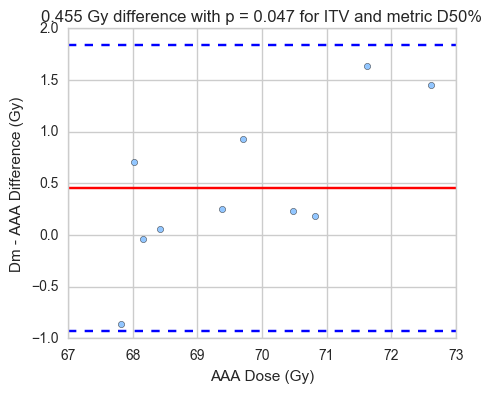

In [21]:
#structure = 'PTV CHEST'
structure = 'ITV'
metric = 'D50%'
plt.figure(figsize=(5, 4)) 
bland_altman_plot(query_data(AAA_Dm_data, 'Dm', structure, metric), query_data(AAA_Dm_data, 'AAA',structure, metric), structure, metric)
plt.show()

## Mean differences

In [22]:
mean_diff_table = AAA_Dm_data.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA')
#percent_diff_table = AAA_Dm_data.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA_%')

In [23]:
mean_diff_table

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DRX,DSD
structure,,,,,,,,,,,
BODY,0.545664,0.613014,-0.048037,-0.014056,-0.002635,0.010526,0.004862,-4.267664,0.861667,0.0,-0.006111
Both Lungs,1.137476,0.721216,0.435794,0.204856,-0.025504,-0.015991,-0.001475,9.764195,1.622500,0.0,0.137500
Both Lungs-ITV,1.193088,0.875368,0.270873,0.130525,-0.016089,-0.013986,-0.004358,4.994661,1.408000,0.0,0.044000
Bronchial tree,-0.004389,-0.002321,-0.008126,0.008418,-0.001513,-0.060785,-0.045982,0.066795,-0.005500,0.0,0.022000
Foramen,-0.315061,-0.282495,-0.279867,-0.268113,-0.074548,0.006426,0.003134,-0.382177,-0.346500,0.0,-0.088000
GTV,-1.152015,-0.396475,-0.510392,-0.383754,-0.861110,-0.695587,-0.898634,0.006202,-0.495000,0.0,0.000000
Heart,-5.632351,5.471829,-0.146496,-0.129145,-0.013560,0.019100,0.027889,-0.314726,0.027500,0.0,-0.066000
ITV,0.582748,0.566858,0.578041,0.569560,0.455339,0.397561,0.266949,0.003390,1.050500,0.0,0.033000
L Brachial plex,-6.238165,-0.568372,-4.751446,-1.579053,2.363519,-0.008431,-0.015921,-32.023725,0.225500,0.0,0.044000


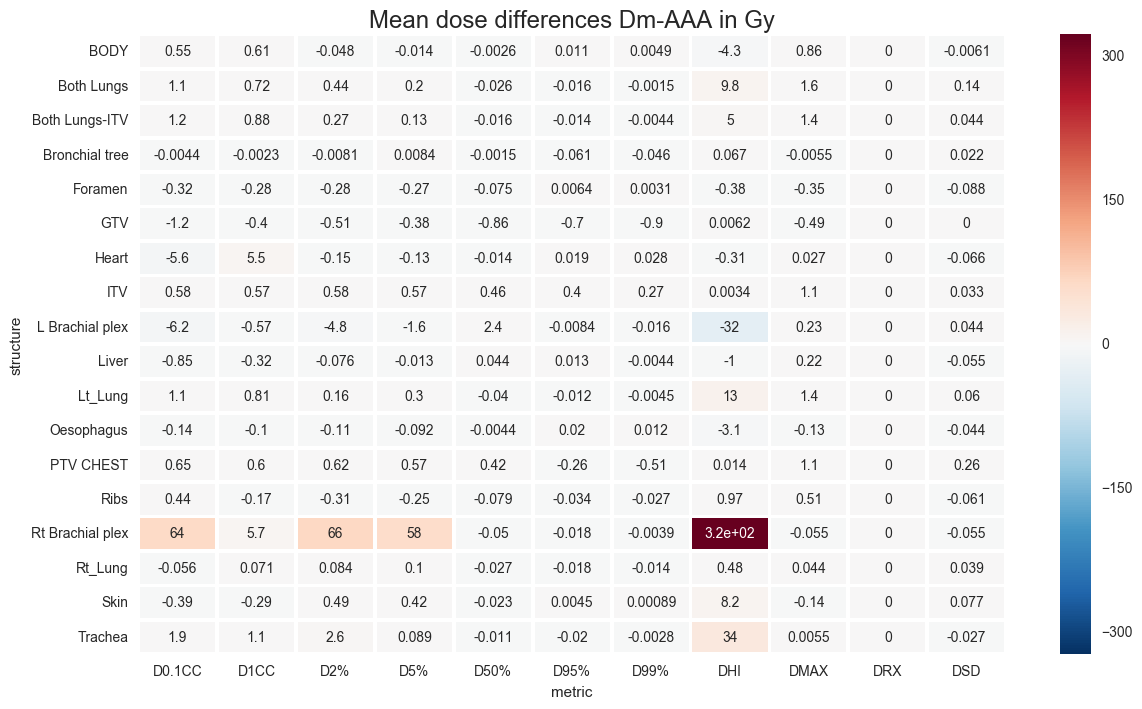

In [24]:
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences Dm-AAA in Gy', size='xx-large')

##  Significance of differences

In [25]:
structures_of_interest   = mean_diff_table.index.values
metrics_of_interest  = mean_diff_table.columns.values

In [26]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [27]:
d = AAA_Dm_data  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA_%']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2413: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure

In [28]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

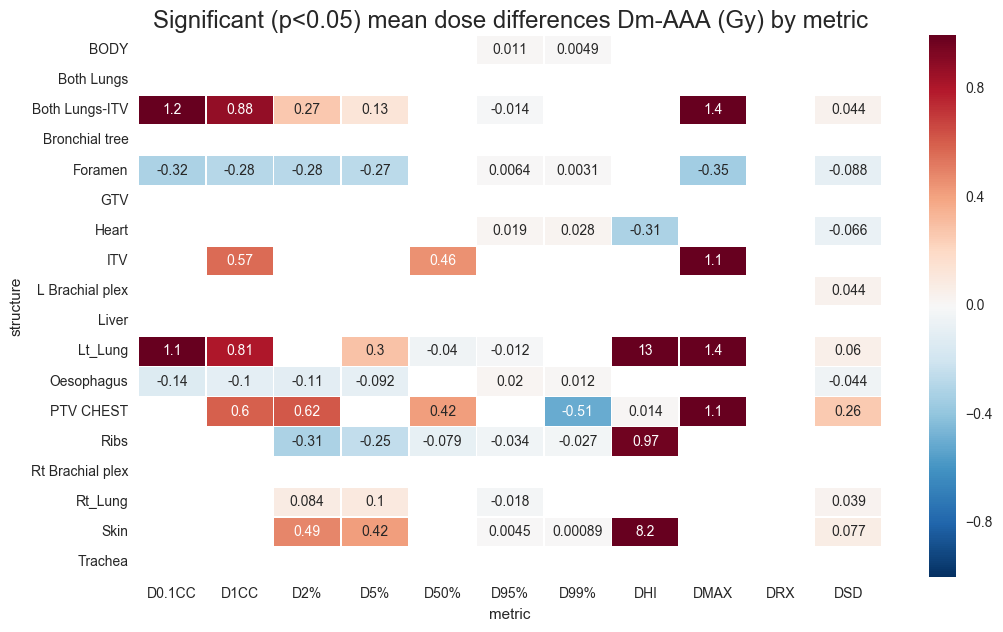

In [29]:
plt.figure(figsize=(12, 7))  
data = mean_diff_table[wilcox_data_df<0.05]
ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0, vmin = -1, vmax = 1.0) #  mask=mask,
ax3.set_title('Significant (p<0.05) mean dose differences Dm-AAA (Gy) by metric', size='xx-large');

## Check for plans that would fail when calc'd with AXB

In [30]:
constraints = pd.read_csv('SABR_lung_constraints.csv')
constraints = constraints.drop('3_Fraction_54Gy', 1)   # drop 54 Gy

In [31]:
constraints = constraints[constraints['metric'].isin(metrics_of_interest)]   # get only constraints where we have exported metrics
constraints

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?
0,PTV CHEST,D95%,>,100,%,1
1,PTV CHEST,D99%,>,90,%,1
2,PTV CHEST,D0.1CC,between,118-134,%,1
3,Foramen,DMAX,<,25,Gy,0
4,Oesophagus,D0.1CC,<,27,Gy,0
5,R Brachial plex,D0.1CC,<,27,Gy,0
6,L Brachial plex,D0.1CC,<,27,Gy,0
7,Heart,D0.1CC,<,27,Gy,0
8,Trachea,D0.1CC,<,32,Gy,0
9,Bronchial tree,D0.1CC,<,32,Gy,0


In [32]:
d = AAA_Dm_data
PTV_D95_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D95%') & (d['AAA'] > 55.0) & (d['Dm'] < 55.0)]
#print(wilcoxon(test_df['diff'])) 
PTV_D95_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
223,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683,-1.375917


In [33]:
PTV_D99_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D99%') & (d['AAA'] > 0.9*55.0) & (d['Dm'] < 0.9*55.0)]
PTV_D99_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [34]:
PTV_D01CC_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D0.1CC') & (((d['AAA'] > 1.18*55) & (d['Dm'] < 1.18*55)) | ((d['AAA'] < 1.34*55) & (d['Dm'] > 1.34*55)))]
PTV_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [35]:
Foramen_D01CC_fail = d[(d['structure'] == 'Foramen') & (d['metric'] == 'DMAX') & (d['AAA'] < 25.0) & (d['Dm'] > 25.0)]
Foramen_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [36]:
Oesophagus_D01CC_fail = d[(d['structure'] == 'Oesophagus') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
Oesophagus_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [37]:
LBrachial_D01CC_fail = d[(d['structure'] == 'L Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
LBrachial_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
490,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653,68225.508432


In [38]:
RBrachial_D01CC_fail = d[(d['structure'] == 'R Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
RBrachial_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [39]:
Heart_D01CC_fail = d[(d['structure'] == 'Heart') & (d['metric'] == 'D0.1CC')& (d['Dm'] > 27.0) & (d['AAA'] < 27.0)]
Heart_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [40]:
Trachea_D01CC_fail = d[(d['structure'] == 'Trachea') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Trachea_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [41]:
Bronchial_D01CC_fail = d[(d['structure'] == 'Bronchial tree') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Bronchial_D01CC_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [42]:
Ribs_V30_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'V30GY') & (d['AAA'] < 30.0) & (d['Dm'] > 30.0)]
Ribs_V30_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%


In [43]:
Liver_D50_fail = d[(d['structure'] == 'Liver') & (d['metric'] == 'D50%') ]
Liver_D50_fail

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
1421,Case22,Liver,D50%,1.250632,1.29488,0.044248,3.538037


In [44]:
failures = PTV_D95_fail
failures = failures.append(PTV_D01CC_fail)
failures = failures.append(LBrachial_D01CC_fail)
failures = failures.append(RBrachial_D01CC_fail)
failures = failures.append(Liver_D50_fail)
print(failures.Case.unique().size)
failures

3


,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
223,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683,-1.375917
490,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653,68225.508432
1421,Case22,Liver,D50%,1.250632,1.294880,0.044248,3.538037
